In [ ]:
import math
import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt
import openpyxl
import cmath
import graphviz
from array import array
import pec_module as pec
import importlib

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator, Statevector
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler

In [ ]:
importlib.reload(pec)

In [97]:
token = "13d9540e280b61b7a4254fcdb05516180957df07523dfef1924f7d9363699a51826b42e7a063b3fb685f295f6d27f8ff61810a97f503a704c07bc959d6cc6e3f"
instance = 'ibm-q-hub-ntu/chen-hong-bin/default'
device = "ibm_aachen"
backend, noise_model = pec.load_ibm_backend(token, instance, device)

In [ ]:
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Get coupling map from backend
coupling_map = [[0, 1], [1, 2], [3, 2], [3, 4]]

backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
backend = AerSimulator(method = "density_matrix")

In [109]:
qubit = 2

#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg_q = QuantumRegister(qubit + 1, 'q')
creg_c = ClassicalRegister(qubit + 1, 'c')
init_state = (np.cos(0), np.sin(0)) 

InitCirZero = QuantumCircuit(qreg_q, creg_c)
InitCirZero.initialize(init_state, qubit)

InitCirOne = QuantumCircuit(qreg_q, creg_c)
InitCirOne.initialize(init_state, qubit)
InitCirOne.x(qubit)

InitCirPlus = QuantumCircuit(qreg_q, creg_c)
InitCirPlus.initialize(init_state, qubit)
InitCirPlus.h(qubit)

InitCirRight = QuantumCircuit(qreg_q, creg_c)
InitCirRight.initialize(init_state, qubit)
InitCirRight.h(qubit)
InitCirRight.s(qubit)

# Store the circuits in a dictionary
InitialState = {'Zero': InitCirZero, 'One': InitCirOne, 'Plus': InitCirPlus, 'Right': InitCirRight}

In [110]:
transpile_circuit = q.compiler.transpile(InitialState['Zero'], backend=backend, optimization_level=0)
backendqubitNum = transpile_circuit.num_qubits

# Store the measurement circuits in a dictionary
pau = ['I', 'X', 'Y', 'Z']
Observable = {f'meas{i}':Pauli('I' * (backendqubitNum-qubit-1) + i + 'I' * qubit) for i in pau}
print(Observable)

{'measI': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'), 'measX': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXII'), 'measY': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYII'), 'measZ': Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII')}


In [111]:
batched_inputs = []
estimator = Estimator(mode=backend)
estimator.options.default_shots = 1000
for MeasName, Measure in Observable.items():
    for InitName, Initial in InitialState.items():
        CirTran = q.compiler.transpile(Initial, backend=backend, optimization_level=0)
        print(CirTran)
        batched_inputs.append((CirTran, Measure))
job_noise = estimator.run(batched_inputs)

                                    
        q_0 -> 0 ───────────────────
                                    
        q_1 -> 1 ───────────────────
                 ┌─────────────────┐
        q_2 -> 2 ┤ Initialize(1,0) ├
                 └─────────────────┘
  ancilla_0 -> 3 ───────────────────
                                    
  ancilla_1 -> 4 ───────────────────
                                    
  ancilla_2 -> 5 ───────────────────
                                    
  ancilla_3 -> 6 ───────────────────
                                    
  ancilla_4 -> 7 ───────────────────
                                    
  ancilla_5 -> 8 ───────────────────
                                    
  ancilla_6 -> 9 ───────────────────
                                    
 ancilla_7 -> 10 ───────────────────
                                    
 ancilla_8 -> 11 ───────────────────
                                    
 ancilla_9 -> 12 ───────────────────
                                    
a

In [103]:
# result
result_noise = job_noise.result()
data = [res.data.evs for res in result_noise]
#Create GramMatrix g
g = np.array(data).reshape(4, 4)
print('g =', '\n', g)

g = 
 [[ 1.          1.          1.          1.        ]
 [-0.01298701  0.002997    0.13886114 -0.02297702]
 [ 0.01698302  0.01298701  0.05294705  0.07692308]
 [ 0.92207792  0.33666334 -0.01098901 -0.03696304]]


In [63]:
#Create State Preparation Matrix A
A = np.array([[1, 1, 1, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1,-1, 0, 0]])

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
# print(A_inv)
B = np.matmul(g, A_inv)
# print(B)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])

B_inv = inv(B)
q_i = np.matmul(a_i, B_inv)
q_x = np.matmul(a_x, B_inv)
q_y = np.matmul(a_y, B_inv)
q_z = np.matmul(a_z, B_inv)
print('B_inv =', '\n', B_inv, '\n')
print('q_i =', '\n', q_i, '\n')
print('q_x =', '\n', q_x, '\n')
print('q_y =', '\n', q_y, '\n')
print('q_z =', '\n', q_z, '\n')

B_inv = 
 [[ 1.          0.          0.          0.        ]
 [ 0.02693274 10.08496346 -4.5159257  -0.64545578]
 [ 0.10216521  0.75189936  9.44177244  4.11053417]
 [ 0.15203964  3.11404104  1.4154732  12.50145931]] 

q_i = 
 [[1. 0. 0. 0.]] 

q_x = 
 [[ 0.02693274 10.08496346 -4.5159257  -0.64545578]] 

q_y = 
 [[0.10216521 0.75189936 9.44177244 4.11053417]] 

q_z = 
 [[ 0.15203964  3.11404104  1.4154732  12.50145931]] 



In [26]:
# IdealMeasure = {f'measI':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_i[0][0], q_i[0][1], q_i[0][2], q_i[0][3]]),
#                 f'measX':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_x[0][0], q_x[0][1], q_x[0][2], q_x[0][3]]),
#                 f'measY':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_y[0][0], q_i[0][1], q_y[0][2], q_y[0][3]]),
#                 f'measZ':SparsePauliOp(['I' * (backendqubitNum-1) + 'I', 'I' * (backendqubitNum-1) + 'X','I' * (backendqubitNum-1) + 'Y','I' * (backendqubitNum-1) + 'Z'], 
#                                     coeffs=[q_z[0][0], q_z[0][1], q_z[0][2], q_z[0][3]])}
# IdealMeasure

In [40]:
# 對應的量子態
testCir = QuantumCircuit(1)
init_state = (np.cos(np.pi/8), np.sin(np.pi/8))  # from θ/2 = π/8

testCir.initialize(init_state, 0)

ErrorObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Z')], coeffs=[-1/np.sqrt(2), 1/np.sqrt(2)])
IdealObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Z')], coeffs=[-q_x[0][1]/np.sqrt(2), q_z[0][3]/np.sqrt(2)])
# IdealObservable = SparsePauliOp([('I' * (backendqubitNum-1) + 'I'), ('I' * (backendqubitNum-1) + 'X'), ('I' * (backendqubitNum-1) + 'Y'), ('I' * (backendqubitNum-1) + 'Z')], 
#                                 coeffs=[(-q_x[0][0]+q_z[0][0])/np.sqrt(2), (-q_x[0][1]+q_z[0][1])/np.sqrt(2), (-q_x[0][2]+q_z[0][2])/np.sqrt(2), (-q_x[0][3]+q_z[0][3])/np.sqrt(2)])
print(ErrorObservable)
print(IdealObservable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[-0.70710678+0.j,  0.70710678+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[-0.70736094+0.j,  0.71061241+0.j])


In [41]:
estimator = Estimator(mode=backend)
batch_error = []
batch_ideal = []
for i in range (50):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    batch_error.append((CirTran, ErrorObservable))
    batch_ideal.append((CirTran, IdealObservable))
job_error = estimator.run(batch_error)
job_ideal = estimator.run(batch_ideal)

In [42]:
result_error = job_error.result()
result_ideal = job_ideal.result()
ErrorExpectation = [res.data.evs for res in result_error]
IdealExpectation = [res.data.evs for res in result_ideal]
print(ErrorExpectation)
print(IdealExpectation)

[array(-0.01208434), array(0.01173908), array(-0.01450121), array(0.01381068), array(0.01519175), array(-0.01519175), array(-0.01898968), array(-0.00759587), array(-0.00690534), array(0.01381068), array(0.00586954), array(0.00241687), array(0.01277488), array(-0.02347815), array(0.01760862), array(-0.01312015), array(-0.0031074), array(-0.01450121), array(0.00690534), array(0.00138107), array(0.00172633), array(0.00172633), array(-0.00483374), array(0.01139381), array(-0.00621481), array(0.00932221), array(0.00621481), array(0.01553701), array(0.00172633), array(-0.0010358), array(-0.00448847), array(-0.01173908), array(-0.00690534), array(-0.00241687), array(0.01622755), array(-0.01519175), array(0.0010358), array(0.00241687), array(0.00759587), array(-0.00241687), array(0.), array(-0.01001274), array(-0.00932221), array(0.00621481), array(-0.00345267), array(0.00656007), array(0.01139381), array(-0.00897694), array(-0.02002549), array(-0.01415595)]
[array(0.01166414), array(0.0088946

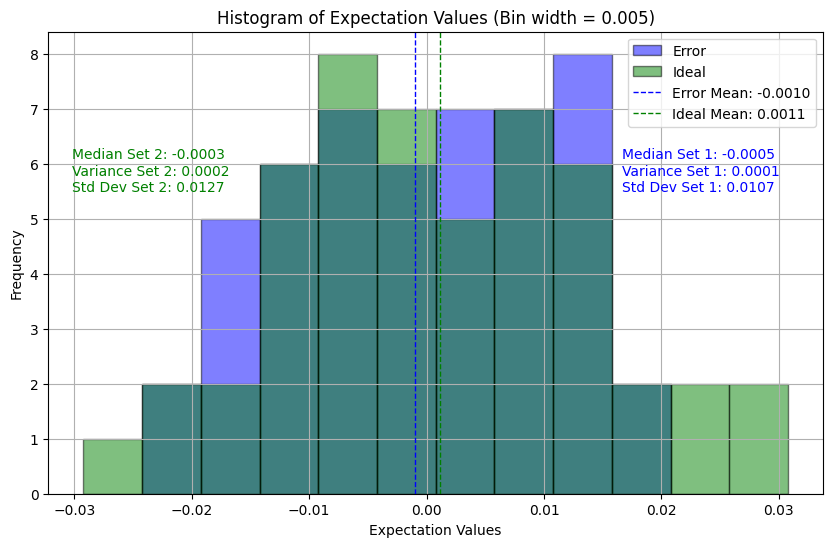

In [47]:
# 假設已經有 ErrorExpectation 和 IdealExpectation 的數據
# ErrorExpectation 和 IdealExpectation 是一維 numpy array

# 設定參數
bin_width = 0.005  # bin 的寬度
bins = np.arange(min(min(ErrorExpectation), min(IdealExpectation)),
                 max(max(ErrorExpectation), max(IdealExpectation)) + bin_width, bin_width)

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(ErrorExpectation, bins=bins, alpha=0.5, label='Error', color='blue', edgecolor='black')
plt.hist(IdealExpectation, bins=bins, alpha=0.5, label='Ideal', color='green', edgecolor='black')

# 計算統計數據
mean_set1 = np.mean(ErrorExpectation)
median_set1 = np.median(ErrorExpectation)
std_dev_set1 = np.std(ErrorExpectation)

mean_set2 = np.mean(IdealExpectation)
median_set2 = np.median(IdealExpectation)
std_dev_set2 = np.std(IdealExpectation)

# 添加統計線
plt.axvline(mean_set1, color='blue', linestyle='dashed', linewidth=1, label=f'Error Mean: {mean_set1:.4f}')
plt.axvline(mean_set2, color='green', linestyle='dashed', linewidth=1, label=f'Ideal Mean: {mean_set2:.4f}')

# 添加標籤、圖例和標題
plt.xlabel('Expectation Values')
plt.ylabel('Frequency')
plt.title('Histogram of Expectation Values (Bin width = 0.005)')
plt.legend(loc='upper right', fontsize=10)

# 添加統計數據注解
plt.text(max(ErrorExpectation)-0.001,5.5,  # 調整位置以適合數據範圍
         f'Median Set 1: {median_set1:.4f}\nVariance Set 1: {np.var(ErrorExpectation):.4f}\nStd Dev Set 1: {std_dev_set1:.4f}',
         color='blue', fontsize=10)

plt.text(min(IdealExpectation)-0.001,5.5,
         f'Median Set 2: {median_set2:.4f}\nVariance Set 2: {np.var(IdealExpectation):.4f}\nStd Dev Set 2: {std_dev_set2:.4f}',
         color='green', fontsize=10)

# 顯示網格
plt.grid(True)
plt.savefig('0511_Aersimulator_50_test.png', dpi=300, bbox_inches='tight')  # 儲存圖檔
plt.show()